# Expected Threat

## Features

- Location of the Action: The pitch is typically divided into zones, and actions are valued based on their starting and ending locations. The closer an action is to the goal, the higher its potential threat value.

- Type of Action: Different actions (e.g., pass, dribble, interception) have different base values. These are adjusted based on the situation and the action's outcome.

- Action Outcome: Where the action ends up, xdest and ydest.

- Transition Between Zones: How an action moves the ball from one zone to another, especially if it significantly increases the chance of scoring, is a critical feature. Moving the ball closer to the opponent's goal, especially into key areas like the penalty box, increases the expected threat.

- Ball Possession State: Whether the team is in possession, trying to regain possession, or transitioning between attack and defense can influence the expected threat value of actions.

- Temporal Aspects: The time left in a match can also affect the xT value of actions. For example, the same action might have a different value in the opening minutes compared to the closing minutes of a closely contested match.

- Contextual Factors: The match context, such as the scoreline, can influence the expected threat value of actions. Teams might take more risks when trailing, affecting the evaluation of actions.

In [359]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_24326/3558712742.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [360]:
# Load the data
allsvenskan = pd.read_csv('csv/allsvenskan_all.csv')
damallsvenskan = pd.read_csv('csv/damallsvenskan_all.csv')
allsvenskan2022 = pd.read_csv('csv/allsvenskan2022.csv')

In [361]:
data = allsvenskan2022

In [362]:
# scale xpos and ypos, xdest and ydest
data['xpos'] = data['xpos'] * 1.2
data['ypos'] = data['ypos'] * 0.8
data['xdest'] = data['xdest'] * 1.2
data['ydest'] = data['ydest'] * 0.8

In [363]:
# Add a new column 'game' that index each game with a unique number
data['game_id'] = (data['external_id'] - data['external_id'].shift(1)).gt(10).cumsum()

# remove the columns: penalty, xg, xp, start_time, end_time, goal_mouth, header
data = data.drop(columns=['penalty', 'xt', 'xp', 'start_time', 'end_time', 'goal_mouth', 'header', 'external_id', 'throw_in'])

data['distance'] = ((data['xpos'] - data['xdest']) ** 2 + (data['ypos'] - data['ydest']) ** 2) ** 0.5

# Add a new column xg that is 0.5 for all rows where xpos > 100 and 0.1 for all rows where xpos < 100
#data['xG'] = 0

# change the otrder of the columns to be game xpos, ypos xdest ydest 
data = data[['game_id', 'game_time', 'xpos', 'ypos', 'xdest', 'ydest', 'distance', 'action', 'attack_type', 'xg', 'player', 'team']]

In [364]:
# Import player_positions csv
player_positions = pd.read_csv('csv/player_positions.csv')

player_positions.rename(columns={'Player Name': 'player'}, inplace=True)

player_positions = player_positions.drop_duplicates(subset='player', keep='first')

merged_df = pd.merge(data, player_positions[['player', 'Position', 'Role']], on='player', how='left')

# renmae Poistion to position and Role to role
merged_df.rename(columns={'Position': 'position', 'Role': 'role'}, inplace=True)

data = merged_df

A. Jeremejeff
63


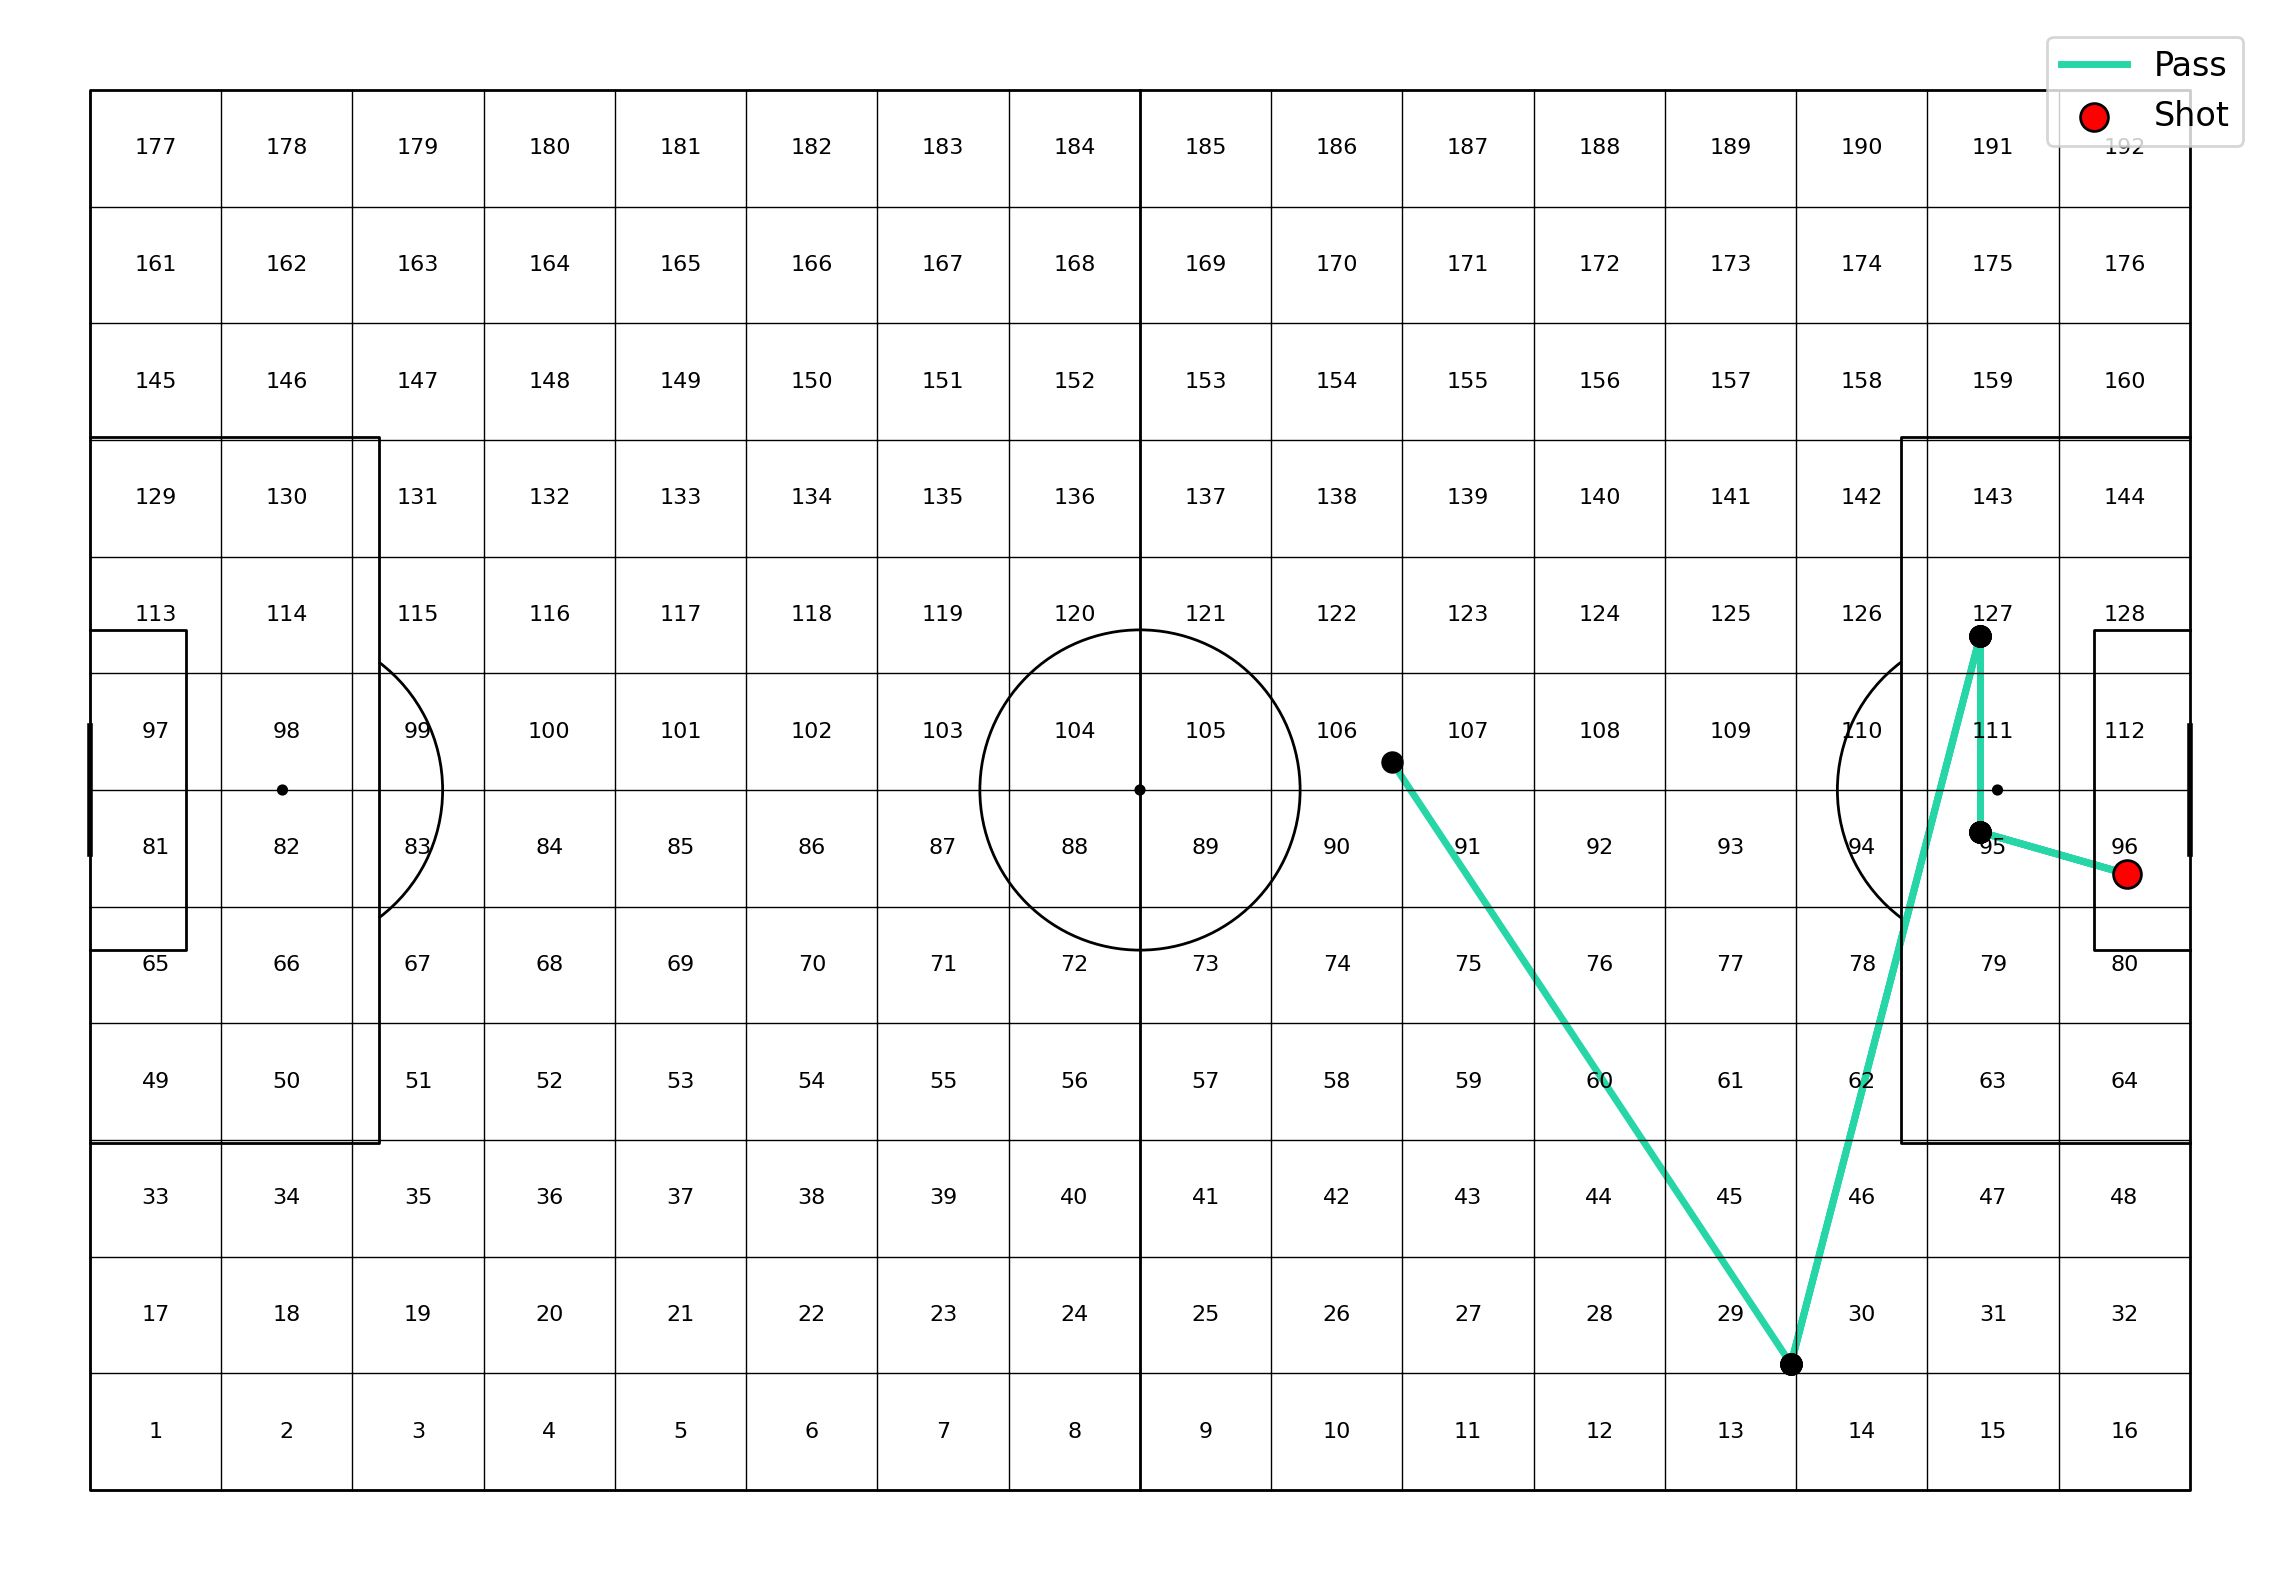

In [365]:
# Setting up the pitch
pitch = Pitch(pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder=2, line_color='black', linewidth=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Grid dimensions
grid_x = 16
grid_y = 12

# Zone dimensions
zone_width = 120 / grid_x
zone_height = 80 / grid_y

# Drawing the grid and numbering the zones
zone_number = 1
for y in range(grid_y):
    for x in range(grid_x):
        # Draw grid lines
        plt.plot([zone_width*x, zone_width*(x+1)], [zone_height*y, zone_height*y], color="black", linewidth=0.5) # Horizontal
        plt.plot([zone_width*x, zone_width*x], [zone_height*y, zone_height*(y+1)], color="black", linewidth=0.5) # Vertical
        
        # Annotate zone number
        plt.text(zone_width*x + zone_width/2, zone_height*y + zone_height/2, str(zone_number),
                 horizontalalignment='center', verticalalignment='center', color="black", fontsize=8)
        zone_number += 1

# Check where a goal was made and take out the 20 rows before the goal
goal_index = data[data['action'] == 'Goal'].index[130]
# print the name of the player that scored the goal
print(data['player'][goal_index])
# Print the game_time of the goal
print(data['game_time'][goal_index])
filtered_data = data.loc[goal_index - 11:goal_index]

# Plot the data
for i in filtered_data.index:
    color = "#4da6ff" if filtered_data['action'][i] == 'Carry' else "#27d6a7" 
    action_label = 'Carry' if filtered_data['action'][i] == 'Carry' else 'Pass'
    plt.plot([filtered_data['xpos'][i], filtered_data['xdest'][i]], [filtered_data['ypos'][i], 
    filtered_data['ydest'][i]], color=color, zorder=1, linewidth=2.5, label=action_label)
    plt.scatter(filtered_data['xpos'][i], filtered_data['ypos'][i], color="black", zorder=2, s=50, edgecolors="black", linewidth=1)
    plt.scatter(filtered_data['xdest'][i], filtered_data['ydest'][i], color="black", zorder=2, s=50, edgecolors="black", linewidth=1)
    if filtered_data['action'][i] == 'Shot':
        plt.scatter(filtered_data['xpos'][i], filtered_data['ypos'][i], color="red", s=100, zorder=3, edgecolors="black", linewidth=1, label='Shot')

# Add a legend that explains the colors
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()

In [366]:
def map_coordinates_to_zone(x, y, pitch_length=120, pitch_width=80, grid_x=16, grid_y=12):
    zone_width = pitch_length / grid_x
    zone_height = pitch_width / grid_y
    
    # Ensure column and row indices do not exceed their maximum values
    column = min(int(x // zone_width), grid_x - 1)
    row = min(int(y // zone_height), grid_y - 1)
    
    zone_number = row * grid_x + column + 1
    
    return zone_number

# use the fucntion for the xpos and ypos
data['start_zone'] = data.apply(lambda x: map_coordinates_to_zone(x['xpos'], x['ypos']), axis=1)
# if xdest and ydest = NaN, make the zone 0
data['end_zone'] = data.apply(lambda x: map_coordinates_to_zone(x['xdest'], x['ydest']) if pd.notnull(x['xdest']) else 0, axis=1)

In [367]:
data.head()

,game_id,game_time,xpos,ypos,xdest,ydest,distance,action,attack_type,xg,player,team,position,role,start_zone,end_zone
0,0,0,58.8,40.8,37.2,43.2,21.732924,Pass accurate,NaN,NaN,E. Andersson,GIF Sundsvall,RM,Midfielder,104,101
1,0,0,37.2,43.2,92.4,80.0,66.342143,Pass inaccurate,NaN,NaN,A. Eriksson,GIF Sundsvall,RM,Midfielder,101,189
2,0,0,28.8,0.0,36.0,11.2,13.314654,Pass accurate,Throw-in,NaN,P. Johansson,Djurgården,CM,Midfielder,4,21
3,0,0,36.0,11.2,40.8,8.0,5.768882,Pass inaccurate,Throw-in,NaN,M. Eriksson,Djurgården,RW,Attacker,21,22
4,0,0,36.0,11.2,NaN,NaN,NaN,Lost ball,Throw-in,NaN,M. Eriksson,Djurgården,RW,Attacker,21,0


In [368]:
shots = data[data['action'] == 'Shot']
shots_per_zone = shots['start_zone'].value_counts().reset_index()

goals = data[data['action'] == 'Goal']
goals_per_zone = goals['start_zone'].value_counts().reset_index()

# Merge the two dataframes on 'start_zone'
merged_df = shots_per_zone.merge(goals_per_zone, on='start_zone', how='outer')

# Rename the columns
merged_df.columns = ['start_zone', 'shots', 'goals']

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Those rows where goals are more than shots, set the goals to 0
merged_df['goals'] = np.where(merged_df['goals'] > merged_df['shots'], 0, merged_df['goals'])

# Define the threshold
threshold = 100

# Calculate the conversion rate of goals per zone
merged_df['conversion_rate'] = np.where(merged_df['shots'] >= threshold, merged_df['goals'] / merged_df['shots'], 0)

# Fill the NaN values with 0
merged_df = merged_df.fillna(0)

# Take the conversion rate and place it in 'data' for the xG, match over the start_zone
#data['xG'] = data['start_zone'].map(merged_df.set_index('start_zone')['conversion_rate'])

# The rows that are non shots and goals, set the xG to 0
#data['xG'] = np.where(data['action'].isin(['Shot', 'Goal']), data['xG'], 0)

In [369]:
data = data[['game_id', 'game_time', 'xpos', 'ypos', 'xdest', 'ydest', 'distance', 'start_zone', 'end_zone', 'action', 'attack_type', 'xg', 'player', 'team', 'position', 'role']]

# Set the xg to 0 for all the areas where there is less than 100 shots taken from that area
data['xg'] = data['start_zone'].map(merged_df.set_index('start_zone')['conversion_rate'])

data.head()

,game_id,game_time,xpos,ypos,xdest,ydest,distance,start_zone,end_zone,action,attack_type,xg,player,team,position,role
0,0,0,58.8,40.8,37.2,43.2,21.732924,104,101,Pass accurate,NaN,NaN,E. Andersson,GIF Sundsvall,RM,Midfielder
1,0,0,37.2,43.2,92.4,80.0,66.342143,101,189,Pass inaccurate,NaN,NaN,A. Eriksson,GIF Sundsvall,RM,Midfielder
2,0,0,28.8,0.0,36.0,11.2,13.314654,4,21,Pass accurate,Throw-in,NaN,P. Johansson,Djurgården,CM,Midfielder
3,0,0,36.0,11.2,40.8,8.0,5.768882,21,22,Pass inaccurate,Throw-in,NaN,M. Eriksson,Djurgården,RW,Attacker
4,0,0,36.0,11.2,NaN,NaN,NaN,21,0,Lost ball,Throw-in,NaN,M. Eriksson,Djurgården,RW,Attacker


## When in possession...

- Move probability M: when a player has possession in zone, how often do they opt to move (i.e. pass or dribble) the ball as their next action?
- Shoot probability S: when a player has possession in zone, how often do they opt to shoot as their next action? In our simplified universe, players can only either move or shoot, so by definition S+M = 100%.
- Move transition matrix T: in the cases where the player moves from zone, what is the probability that they move to each of the other zones?
- Goal probability G: in the cases where the player shoots from zone, what is the probability that the shot turns into a goal?

In [370]:
# Filter for move and shot actions
move_actions = data[(data['action'] == 'Pass accurate') | (data['action'] == 'Carry') | (data['action'] == 'Pass inaccurate')]
shot_actions = data[data['action'] == 'Shot']

# Count total moves and shots from each zone
move_counts = move_actions.groupby('start_zone').size().rename('move_counts')
shot_counts = shot_actions.groupby('start_zone').size().rename('shot_counts')

# Fill missing zones with 0
move_counts = move_counts.reindex(range(1, grid_x * grid_y + 1), fill_value=0)
shot_counts = shot_counts.reindex(range(1, grid_x * grid_y + 1), fill_value=0)

# Combine move and shot counts, fill missing values with 0
zone_actions = pd.concat([move_counts, shot_counts], axis=1)

# Calculate Move (M) and Shoot (S) probabilities
zone_actions['M'] = zone_actions['move_counts'] / (zone_actions['move_counts'] + zone_actions['shot_counts'])
zone_actions['S'] = zone_actions['shot_counts'] / (zone_actions['move_counts'] + zone_actions['shot_counts'])

# Create M and S to numpy array
M = zone_actions['M'].values
S = zone_actions['S'].values

# Reshape M and S into 16x12 matrices
M = np.reshape(M, (12, 16))
S = np.reshape(S, (12, 16))

# Print the shapes of the arrays
print("Shape of M:", M.shape)
print("Shape of S:", S.shape)

Shape of M: (12, 16)
Shape of S: (12, 16)


In [371]:
# Calculate total moves from each start zone to end zone
move_transitions = move_actions.groupby(['start_zone', 'end_zone']).size().reset_index(name='transition_counts')

# Convert start_zone and end_zone from 1D to 2D
move_transitions['start_zone_x'] = (move_transitions['start_zone'] - 1) % grid_x
move_transitions['start_zone_y'] = (move_transitions['start_zone'] - 1) // grid_x
move_transitions['end_zone_x'] = (move_transitions['end_zone'] - 1) % grid_x
move_transitions['end_zone_y'] = (move_transitions['end_zone'] - 1) // grid_x

# Pivot table to create matrix form, rows as start zones, columns as end zones
T_matrix = move_transitions.pivot_table(index=['start_zone_x', 'start_zone_y'], columns=['end_zone_x', 'end_zone_y'], values='transition_counts', fill_value=0)

# Normalize by row to get probabilities
T_matrix = T_matrix.div(T_matrix.sum(axis=1), axis=0)

# Convert DataFrame to numpy array and reshape to 4D
T = T_matrix.values.reshape((grid_y, grid_x, grid_y, grid_x))

print('Shape of T:', T.shape)

Shape of T: (12, 16, 12, 16)


In [372]:
# Assuming shots with xG > 0 have a chance to be goals
goal_probabilities = shot_actions.groupby('start_zone')['xg'].mean().rename('G')

# Fill missing zones with 0
goal_probabilities = goal_probabilities.reindex(range(1, grid_x * grid_y + 1), fill_value=0)

# Convert to numpy array and reshape to 16x12 matrix
G = goal_probabilities.values.reshape((12, 16))

print("Shape of G:", G.shape)

Shape of G: (12, 16)


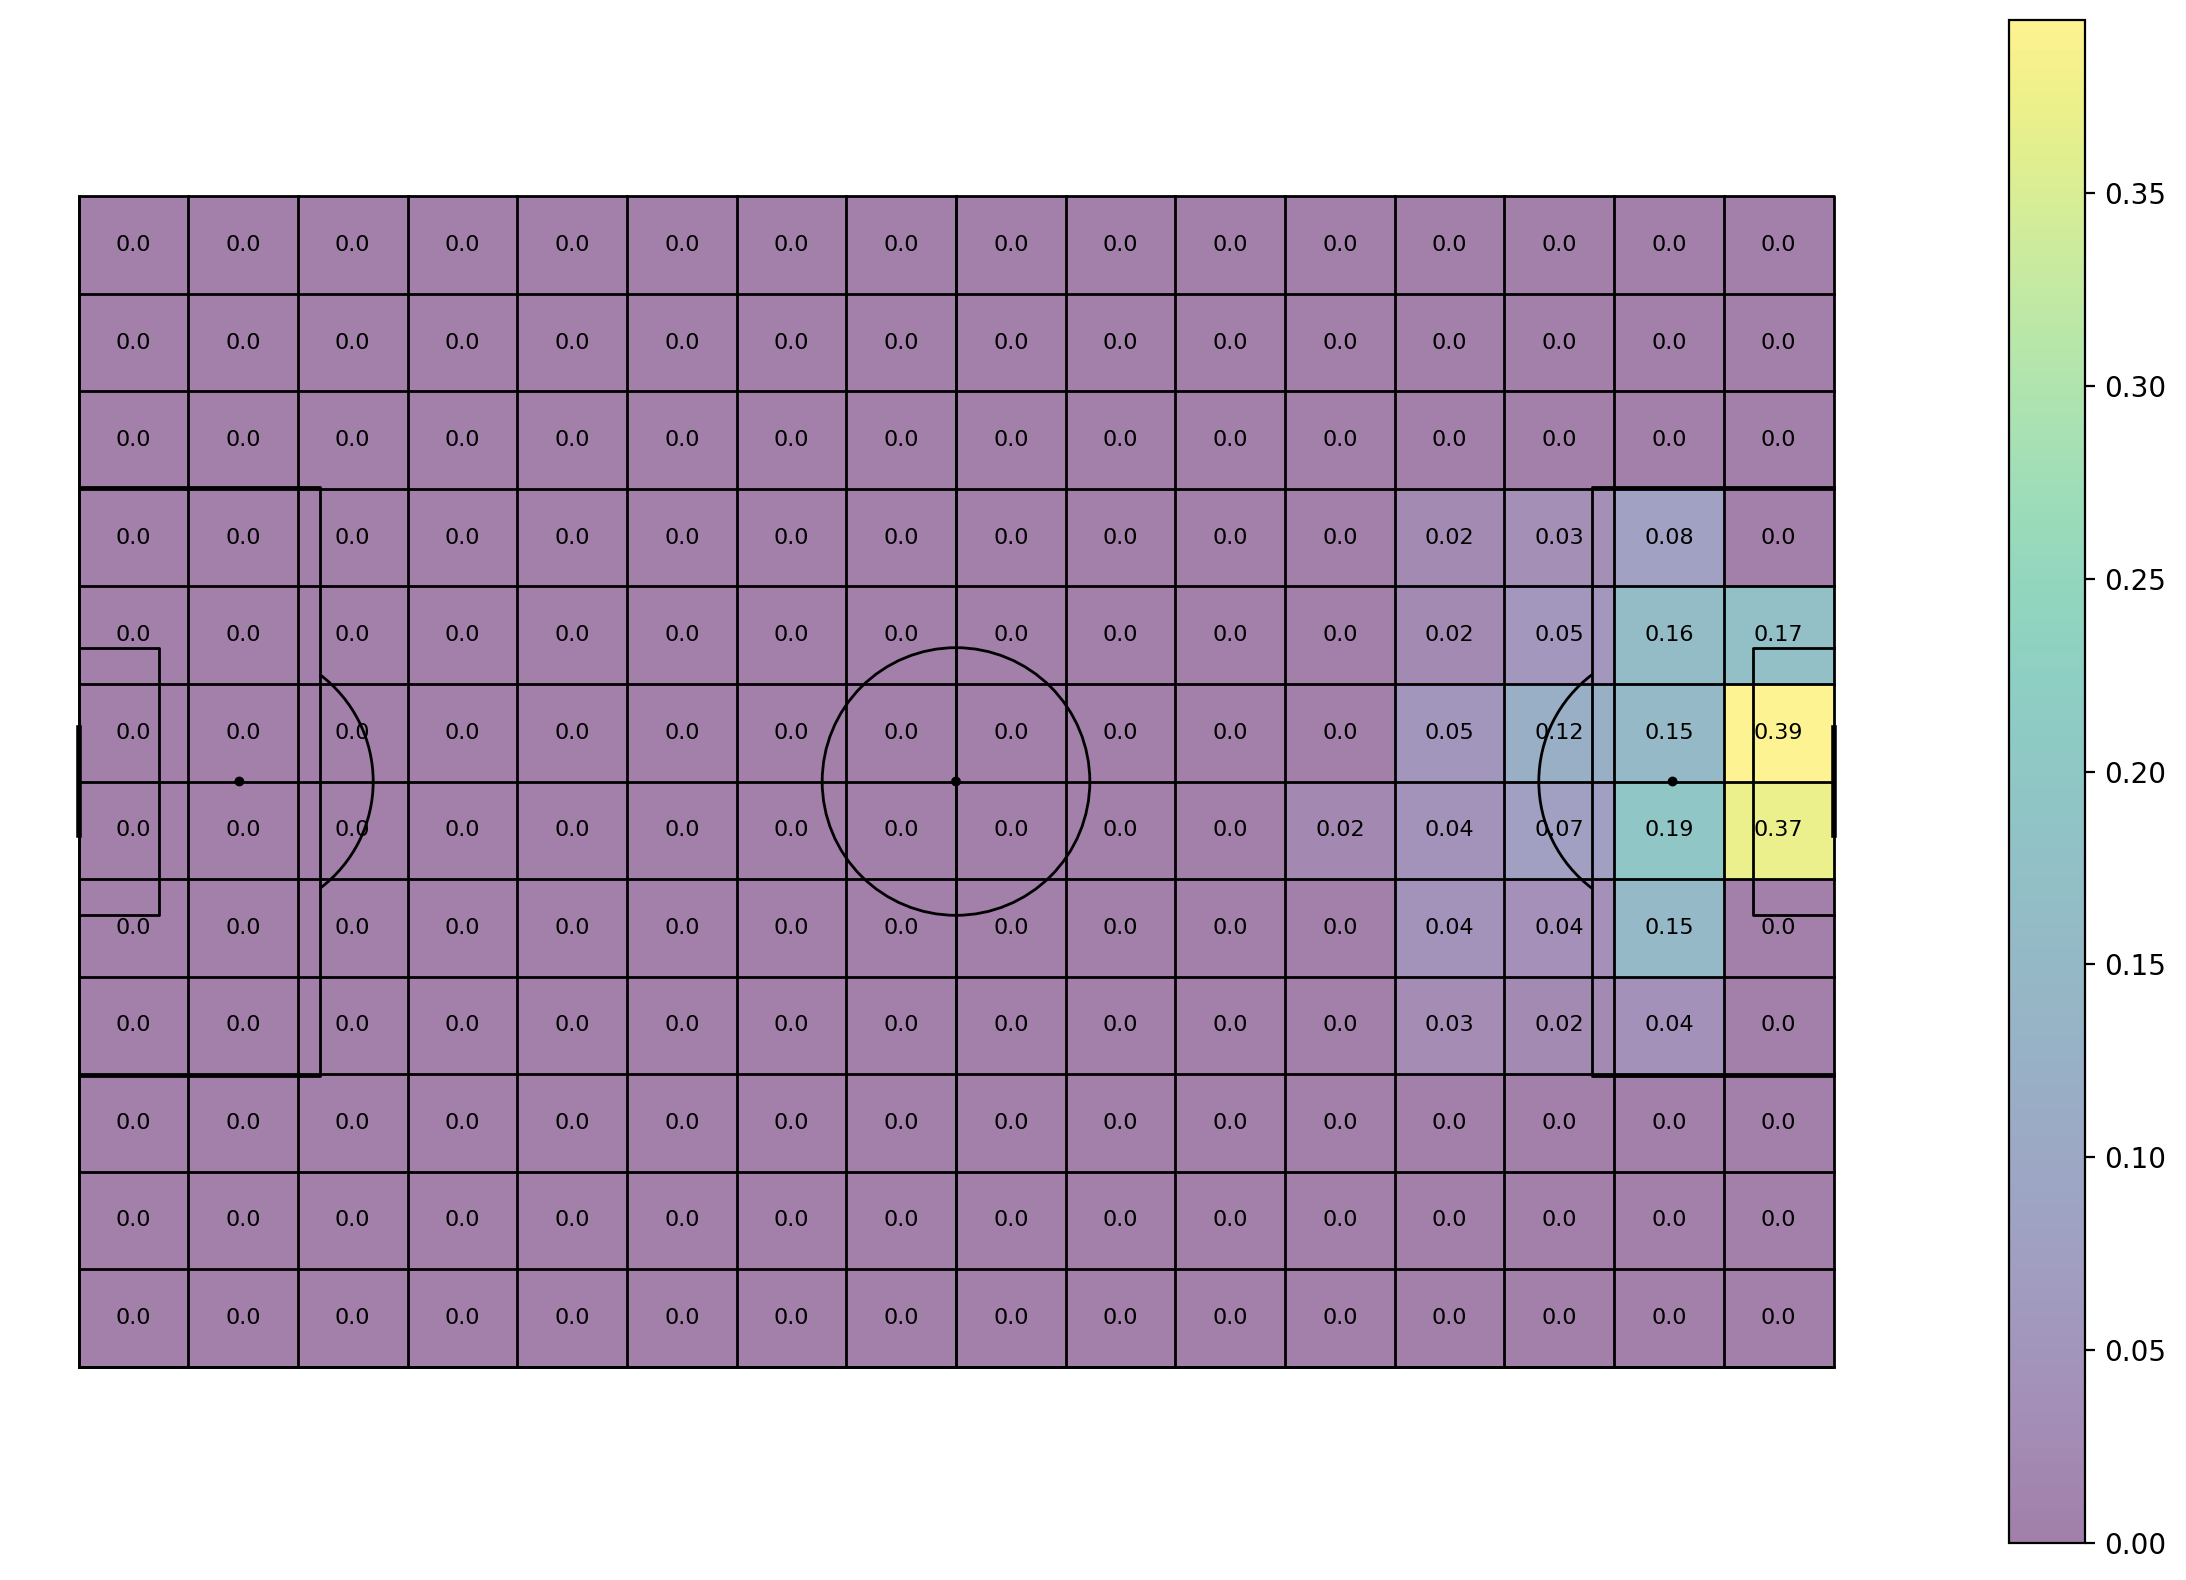

In [373]:
# Setting up the pitch
pitch = Pitch(pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder=2, line_color='black', linewidth=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Grid dimensions
grid_x = 16
grid_y = 12

# Zone dimensions
zone_width = 120 / grid_x
zone_height = 80 / grid_y

# Drawing the grid and numbering the zones
for y in range(grid_y):
    for x in range(grid_x):
        # Draw grid lines
        plt.plot([zone_width*x, zone_width*(x+1)], [zone_height*y, zone_height*y], color="black", linewidth=1) # Horizontal
        plt.plot([zone_width*x, zone_width*x], [zone_height*y, zone_height*(y+1)], color="black", linewidth=1) # Vertical
        
        # Annotate G value
        plt.text(zone_width*x + zone_width/2, zone_height*y + zone_height/2, str(round(G[y, x], 2)),
         horizontalalignment='center', verticalalignment='center', color="black", fontsize=8)

# Create a heatmap and overlay it on the pitch
heatmap = plt.imshow(G, cmap='viridis', interpolation='nearest', extent=[0, 120, 80, 0], alpha=0.5)

# Add a colorbar for the heatmap
plt.colorbar(heatmap, ax=ax)

plt.tight_layout()
plt.show()

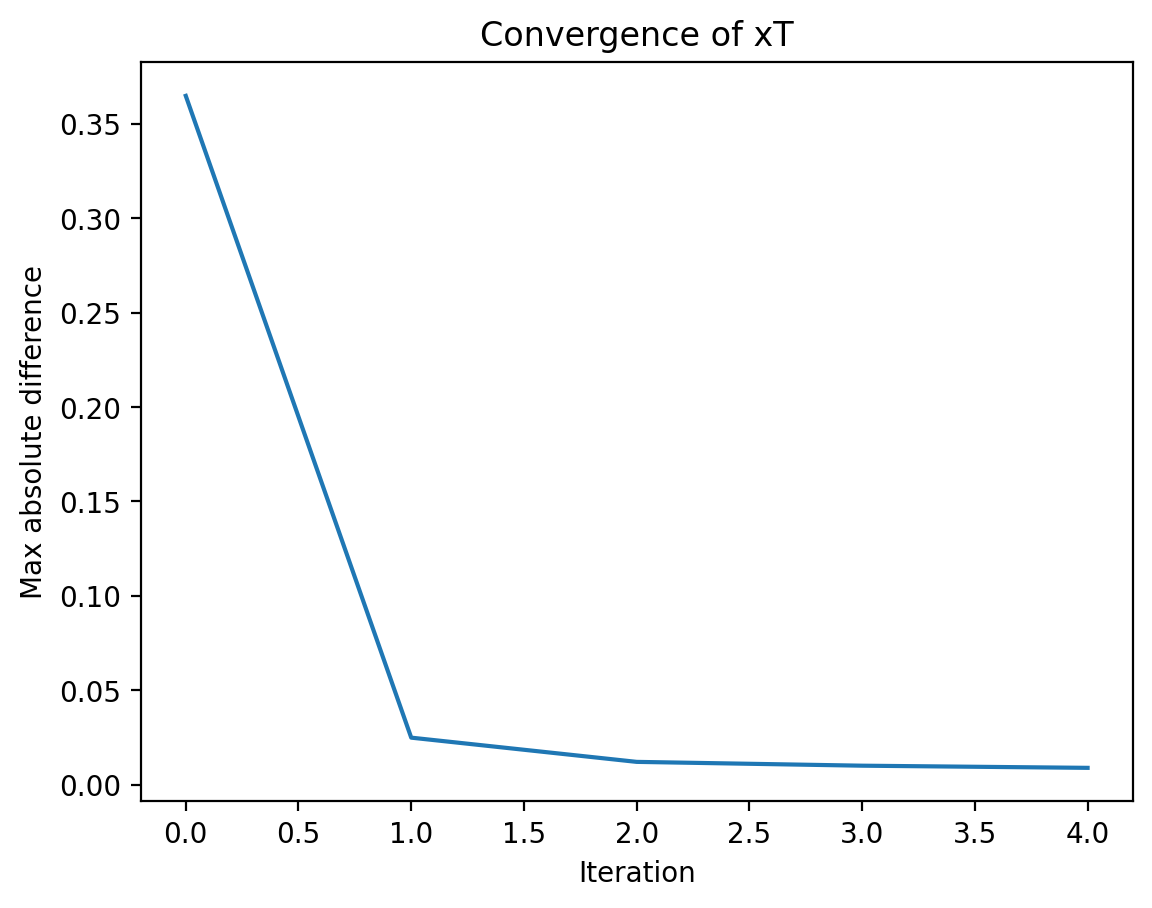

In [374]:
def compute_xT(M, S, T, G, tolerance=0.001, max_iterations=5):
    num_zones_x, num_zones_y = M.shape
    xT = np.zeros((num_zones_x, num_zones_y))  # Initial xT values
    convergence = []  # List to store convergence values
    
    for iteration in range(max_iterations):
        new_xT = np.zeros((num_zones_x, num_zones_y))
        for x in range(num_zones_x):
            for y in range(num_zones_y):
                shooting_payoff = S[x, y] * G[x, y]  # Payoff from shooting
                moving_payoff = 0  # Payoff from moving
                
                # Calculate expected payoff from moving
                for z in range(num_zones_x):
                    for w in range(num_zones_y):
                        moving_payoff += T[x, y, z, w] * xT[z, w]
                
                # Combine payoffs
                new_xT[x, y] = shooting_payoff + (M[x, y] * moving_payoff)
        
        # Check for convergence
        convergence_value = np.max(np.abs(new_xT - xT))
        convergence.append(convergence_value)
        if convergence_value < tolerance:
            break
        xT = new_xT

    return xT, convergence

xT, convergence = compute_xT(M, S, T, G)

# Plot the convergence
plt.plot(convergence)
plt.xlabel('Iteration')
plt.ylabel('Max absolute difference')
plt.title('Convergence of xT')
plt.show()

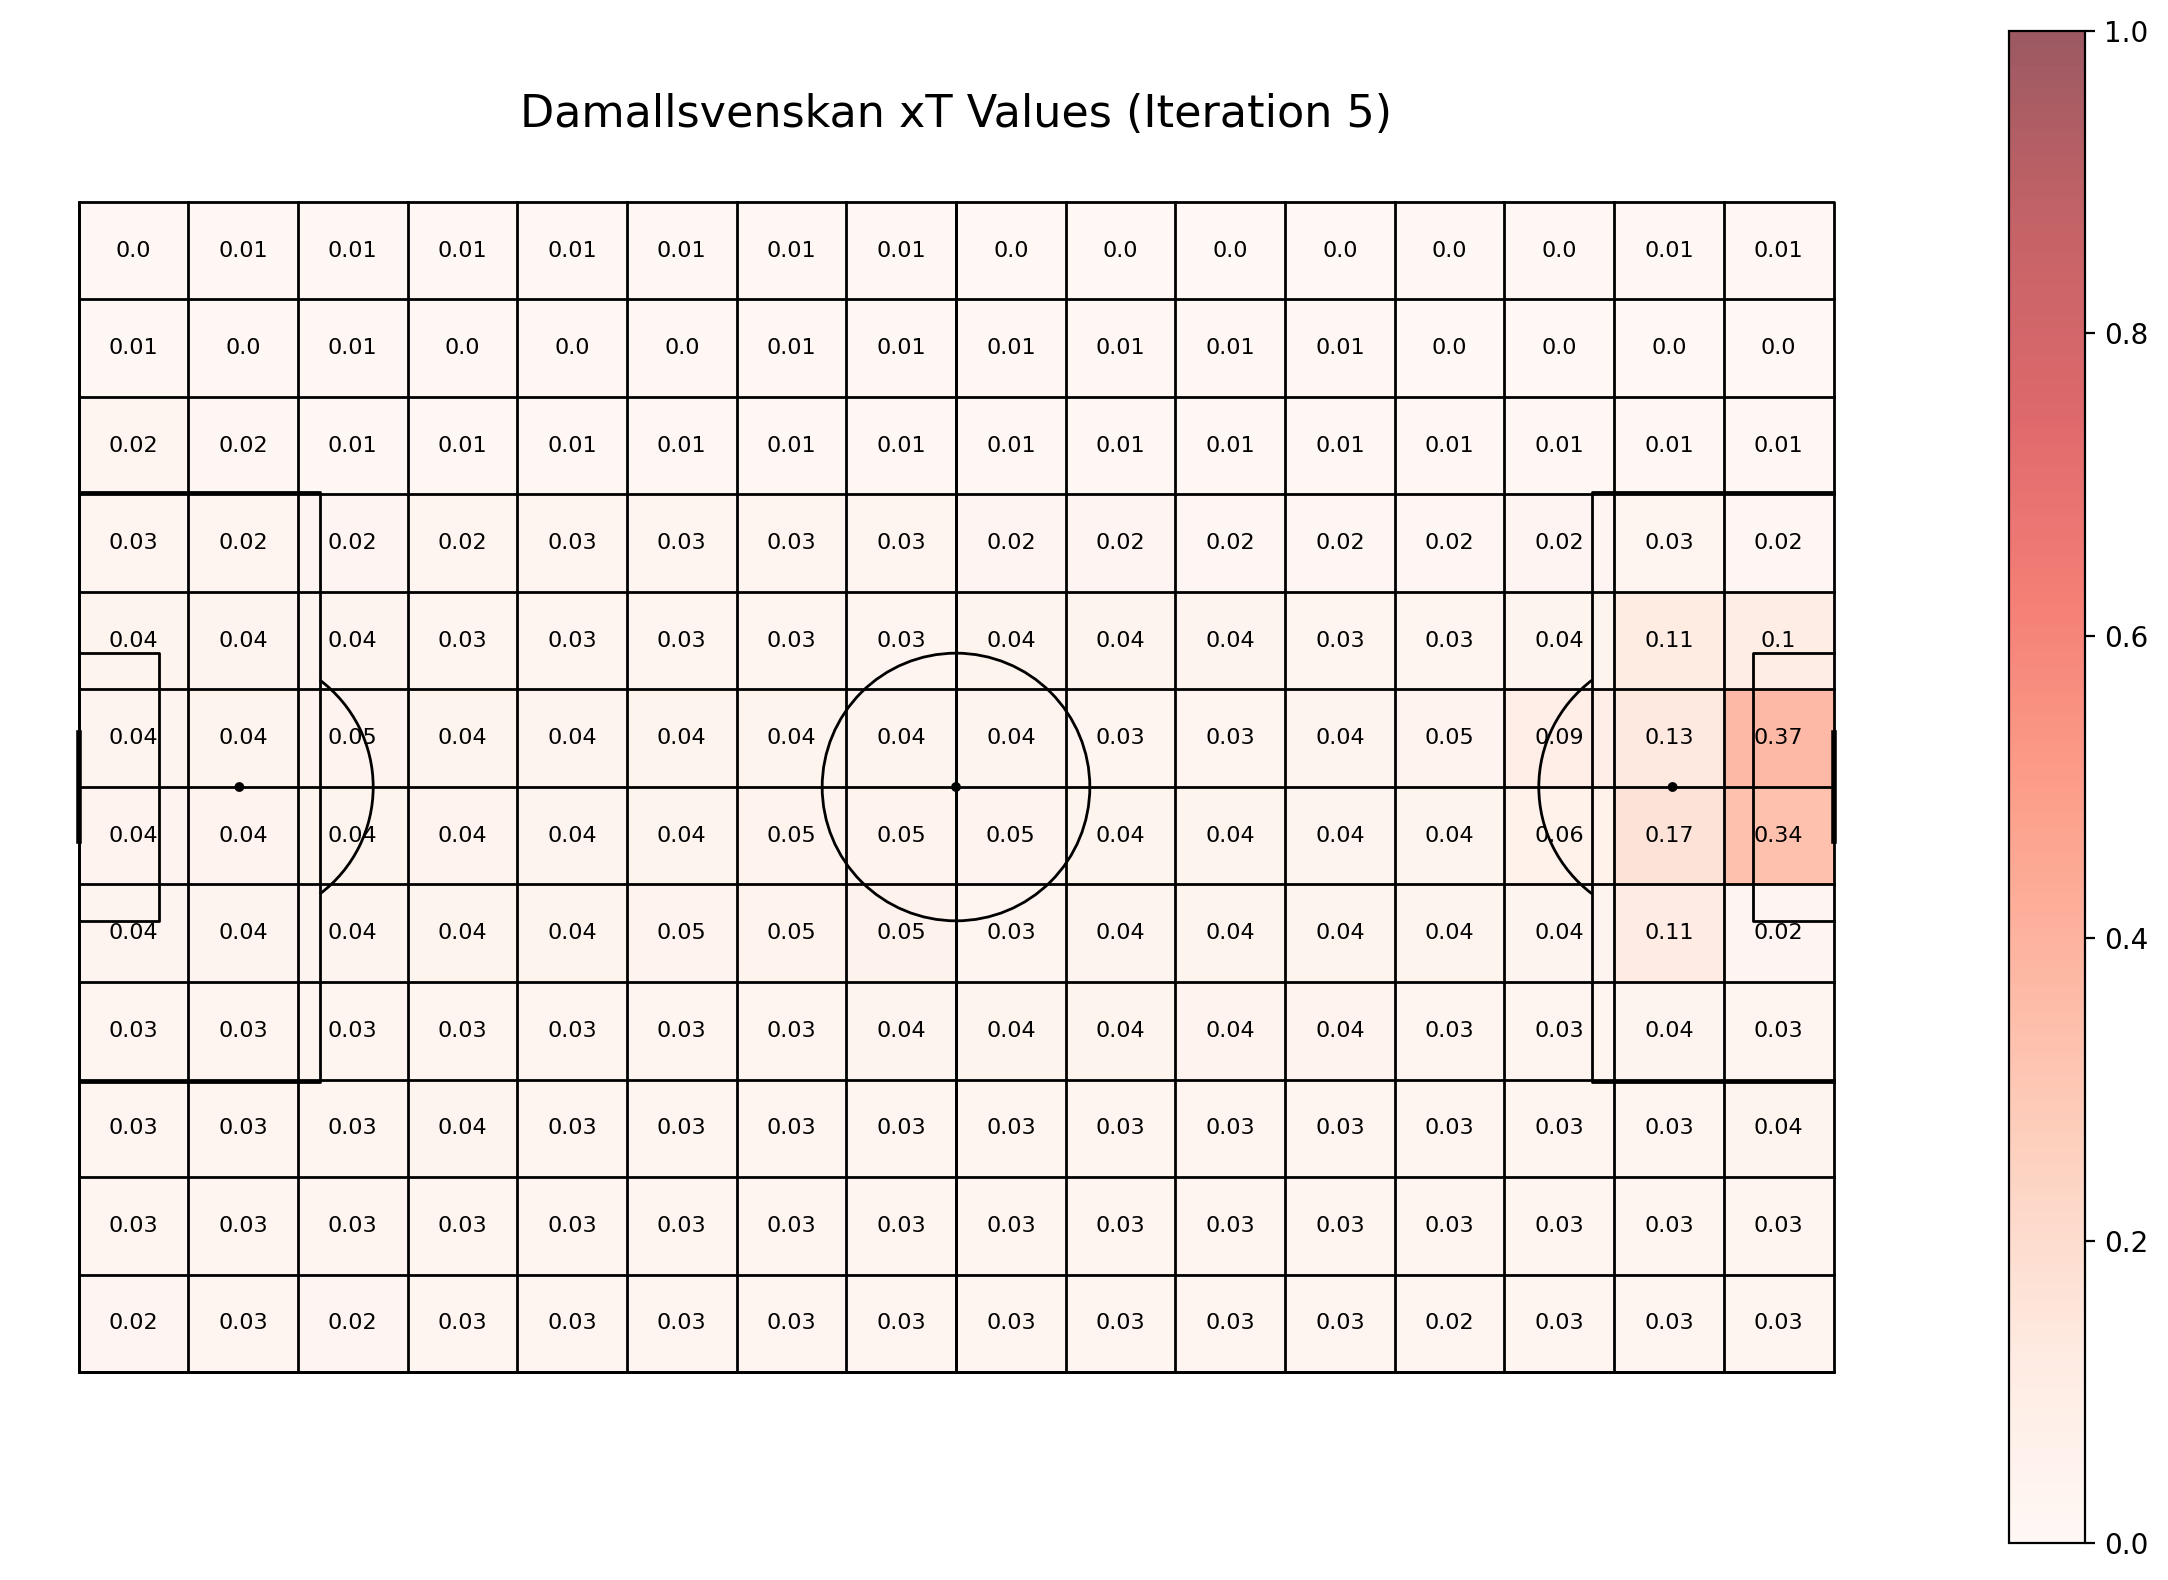

In [375]:
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.colors import Normalize

# Setting up the pitch
pitch = Pitch(pitch_type='custom', pitch_length=120, pitch_width=80, line_zorder=2, line_color='black', linewidth=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Grid dimensions
grid_x = 16
grid_y = 12

# Zone dimensions
zone_width = 120 / grid_x
zone_height = 80 / grid_y

# Drawing the grid and numbering the zones
for y in range(grid_y):
    for x in range(grid_x):
        # Draw grid lines
        plt.plot([zone_width*x, zone_width*(x+1)], [zone_height*y, zone_height*y], color="black", linewidth=1) # Horizontal
        plt.plot([zone_width*x, zone_width*x], [zone_height*y, zone_height*(y+1)], color="black", linewidth=1) # Vertical
        
        # Annotate xT value
        # Annotate xT value
        plt.text(zone_width*x + zone_width/2, zone_height*y + zone_height/2, str(round(xT[y, x], 2)),
         horizontalalignment='center', verticalalignment='center', color="black", fontsize=8)

# Normalize the colormap
#norm = Normalize(vmin=0, vmax=1)

# Create a heatmap and overlay it on the pitch
heatmap = plt.imshow(xT, cmap='Reds', interpolation='nearest', extent=[0, 120, 80, 0], alpha=0.65, vmin=0, vmax=1)

# Add a colorbar for the heatmap
plt.colorbar(heatmap, ax=ax)

# Add a title
plt.title('Damallsvenskan xT Values (Iteration 5)', fontsize=16)

plt.tight_layout()
plt.show()

In [376]:
# Now that we have the xT for each zone, we can put those values into a dataframe
xT_df = pd.DataFrame(xT, columns=[f'X {i+1}' for i in range(grid_x)])
xT_df.index = [f'Y {i+1}' for i in range(grid_y)]

# We need to convert the numbers of the zones to 1-192
xT_df = xT_df.stack().reset_index()
xT_df.columns = ['Y', 'X', 'xT']

# Add a new column 'zone_number' that mimics the index
xT_df = xT_df.reset_index().rename(columns={'index': 'zone_number'})

# Adjust 'zone_number' to start from 1 instead of 0
xT_df['zone_number'] += 1

# Round xt to 2 decimal places
xT_df['xT'] = xT_df['xT']

xT_df.head()

,zone_number,Y,X,xT
0,1,Y 1,X 1,0.021040
1,2,Y 1,X 2,0.025584
2,3,Y 1,X 3,0.021849
3,4,Y 1,X 4,0.027008
4,5,Y 1,X 5,0.028754


In [377]:
# Now that we have the xT for each zone_number, we can add those back to the original dataframe.
# Create start_zone xt and end_zone xt
data['start_zone_xt'] = data['start_zone'].map(xT_df.set_index('zone_number')['xT'])
data['end_zone_xt'] = data['end_zone'].map(xT_df.set_index('zone_number')['xT'])

data['xT_diff'] = data['end_zone_xt'] - data['start_zone_xt']

# Take out the players with the most xT_diff in total for the season and what team they play for and their role
players = data.groupby('player')['xT_diff'].sum().reset_index().sort_values(by='xT_diff', ascending=False)

# Round to two decimals 
players['xT_diff'] = players['xT_diff'].round(2)

# match the player name with 'data' and take out the team and role
players = players.merge(data[['player', 'team']], on='player', how='left').drop_duplicates(subset='player', keep='first').reset_index(drop=True)

players.head(20)

,player,xT_diff,team
0,J. Levi,76.78,IFK Norrköping
1,M. Eriksson,74.90,Djurgården
2,M. Jeahze,73.35,Hammarby
3,J. Larsson,63.10,AIK
4,D. Campos,62.13,Degerfors
5,A. Johansson,58.47,Varberg
6,O. Wendt,58.29,IFK Göteborg
7,N. Persson,57.97,Mjällby
8,V. Davidsen,55.58,Helsingborg
9,O. Johansson,52.18,Värnamo


In [378]:
# I have a scenario where the ball is moved like this:
# Pass from 162 to 131
# Carry from 131 to 100
# Pass from 100 to 87
# Carry from 87 to 90
# Pass from 90 to 63
# Pass from 63 to 112
# Goal is scored from 112

# Help me calucate the increase in xT for each event

# Take out the xT for each zone
value_106 = xT_df[xT_df['zone_number'] == 106]['xT'].values[0].round(2)
value_29 = xT_df[xT_df['zone_number'] == 29]['xT'].values[0].round(2)
value_127 = xT_df[xT_df['zone_number'] == 127]['xT'].values[0].round(2)
value_95 = xT_df[xT_df['zone_number'] == 95]['xT'].values[0].round(2)
value_96 = xT_df[xT_df['zone_number'] == 96]['xT'].values[0].round(2)


# difference in xT for each event
pass_1 = value_29 - value_106
pass_2 = value_127 - value_29
pass_3 = value_95 - value_127
pass_4 = value_96 - value_95

# Print the difference in xT for each event
print("Increase in xT for each event:")
print(f"Pass 1: {pass_1}")
print(f"Pass 2: {pass_2}")
print(f"Pass 3: {pass_3}")
print(f"Pass 4: {pass_4}")

Increase in xT for each event:
Pass 1: 0.0
Pass 2: 0.08
Pass 3: 0.06000000000000001
Pass 4: 0.17


Jeremejeff xT for each pass

Increase in xT for each event:

- Pass 1: 0.0
- Pass 2: 0.08
- Pass 3: 0.1
- Pass 4: 0.15000000000000002